Тетрадка с проектом состоит из 3 частей:

    В первой части содержится первоначальная информация от заказчика. Нами проводится первичный анализ данных и формируются уточняющие по данным и целям проекта вопросы к заказчику. После в рамках учебной программы тимлид, в роли заказчика, отвечает на поставленные нами вопросы. Эти ответы будут отдельно выписаны нами в конце первой части. 

    Во второй части, учитывая наш анализ данных и ответы заказчика, мы проводим сбор и предобработку данных для моделей из ранее предоставленных заказчиком файлов. Обучаем модели и тестируем лучшую. 

    В третьей части формируется отчёт для заказчика по проделанной работе. Приводятся гиперпараметры и результаты метрики лучшей модели.

# Выпускной проект: Промышленность.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

Заказчик также сообщил нам описание этапа обработки:

    Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

    Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

    Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

    Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Заказчик предоставил нам следующие данные:

    data_arc_new.csv — данные об электродах;
    
    data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    
    data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    
    data_gas_new.csv — данные о продувке сплава газом;
    
    data_temp_new.csv — результаты измерения температуры;
    
    data_wire_new.csv — данные о проволочных материалах (объём);
    
    data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from tqdm import tqdm

## Анализ данных и формирование вопросов

### Данные об электродах

In [3]:
#данные об электродах
electrodes = pd.read_csv('/datasets/data_arc_new.csv')
electrodes.info()
electrodes.head(7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527


In [4]:
#проверим наши данные на явные дубликаты
electrodes.duplicated().sum()

0

<AxesSubplot:>

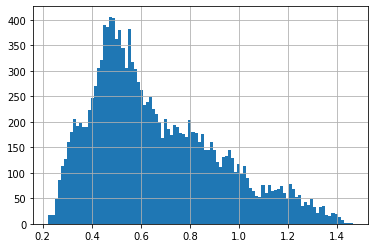

In [5]:
electrodes['Активная мощность'].hist(bins=100)

<AxesSubplot:>

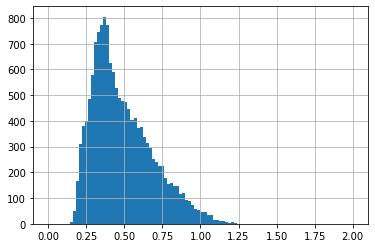

In [6]:
# почему график не строится нормально без range???
electrodes['Реактивная мощность'].hist(bins=100, range=(0, 2))

In [7]:
electrodes.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Посмотрим как много отрицательных значений мощностей в данных.

In [8]:
electrodes[electrodes['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Всего одна строчка у партии 2116. 

Перейдем к построению диаграммы размаха. 

<AxesSubplot:>

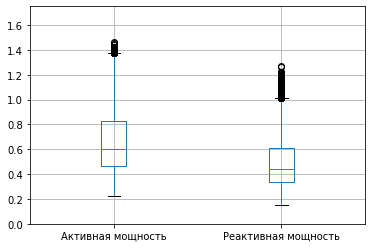

In [9]:
plt.grid(True)
plt.ylim(0, 1.75)
electrodes[['Активная мощность', 'Реактивная мощность']].boxplot()

In [10]:
#узнаем какой промежуток времени указан в данных
electrodes['Начало нагрева дугой'] = pd.to_datetime(electrodes['Начало нагрева дугой'])
electrodes['Конец нагрева дугой'] = pd.to_datetime(electrodes['Конец нагрева дугой'])
print('Начало нагрева дугой: c ', electrodes['Начало нагрева дугой'].min(), 'по',
electrodes['Начало нагрева дугой'].max())
print('Конец нагрева дугой: c ', electrodes['Конец нагрева дугой'].min(), 'по',
electrodes['Конец нагрева дугой'].max())

Начало нагрева дугой: c  2019-05-03 11:02:14 по 2019-09-06 17:24:54
Конец нагрева дугой: c  2019-05-03 11:06:02 по 2019-09-06 17:26:15


Проверим данные на хронологическую последовательность. 

In [11]:
electrodes['Начало нагрева дугой'].is_monotonic

True

In [12]:
electrodes['Конец нагрева дугой'].is_monotonic

True

Подведём итог. 

Данные об электродах не содержат пропусков и явных дубликатов. По времени данные содержат информацию за 2019 год с 3 мая 11 часа по 6 сентября 17 часа. 

Указанные две мощности содержат выбросы. Часть выбросов в “Реактивной  мощности” явно является ошибочными данными, так как содержат отрицательные показатели. Данные с такими показателями мы предлагаем сразу удалить, возможно нужно будет удалить все данные партии в которых встречаются ошибочные показателями. 

Другие выбросы, те что не отрицательные, скорее всего нужно будет оставить, так как в будущем уже готовой модели всё равно придётся встретиться с такими показателями, поэтому стоит её заранее обучать и на них тоже. 

К заказчику у нас есть несколько вопросов:

    На нагрев дуги влияют обе мощности? И как-то они связаны друг с другом?
    
    Отрицательные значения мощностея явялются не нормальными? 
    
    Показатели мощностей в большинстве своём пребывают в диапазоне от 0 до 1. Нас смущает что встречаются показатели больше 1, такое может быть?

### Данные о подаче сыпучих материалов

Два следующих датафрейма связаны, поэтому проанализируем их вместе. 

In [13]:
#данные о подаче сыпучих материалов (объём)
bulk_volume = pd.read_csv('/datasets/data_bulk_new.csv') 
bulk_volume.info()
bulk_volume.head(7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0


In [14]:
#данные о подаче сыпучих материалов (время)
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv') 
bulk_time.info()
bulk_time.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16


Разумно предположить что две таблицы связаны следующим образом: в первой таблице указывается объём того или иного сыпучего материала который был использован для определённой партии, во второй же таблице в столбце с номером этого же этой же партии и этого же сыпучего материала указывается время его подачи.

Но на всякий случай проверим совпадает ли количество значений в датафреймах сыпучих материалов.

In [15]:
v_c = bulk_volume.count()
t_c = bulk_time.count()
df_1 = pd.DataFrame([v_c, t_c])
df_1

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,3129,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
1,3129,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248


Совпадает

Проверим таблицу с объёмом сыпучих материалов, ящик с усами для каждого вида материалов строить не будем, так как мы уже решили использовать все выбросы для обучения модели, кроме явно ошибочных показателей. Добавим также столбец general с общей суммой добавок по партиям.

In [16]:
bulk_volume['general bulk']=bulk_volume.drop('key', axis=1).sum(axis=1)

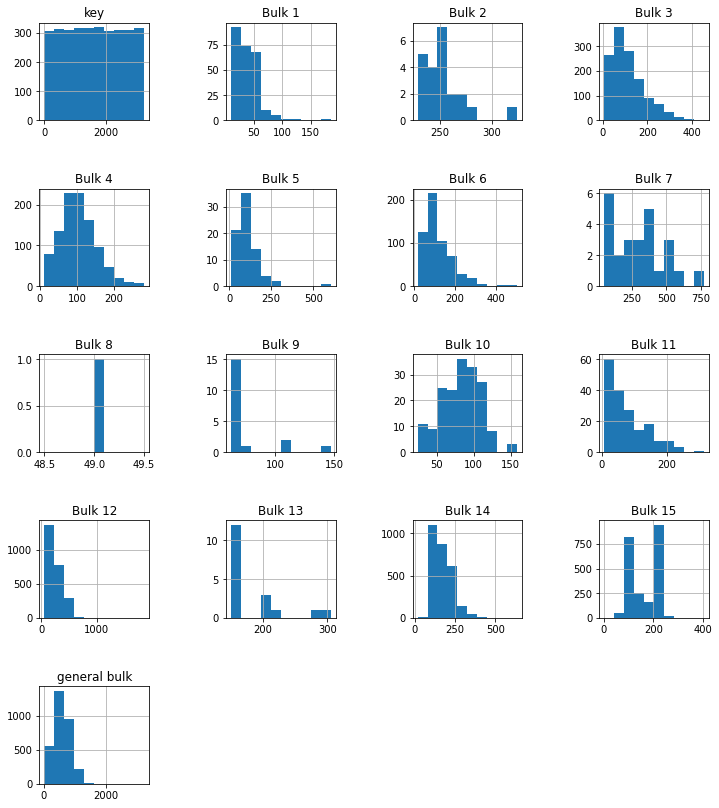

In [17]:
bulk_volume.hist(figsize=(12,14))
plt.subplots_adjust(hspace=0.7, wspace=0.7)
plt.show()

In [18]:
bulk_volume.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,general bulk
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000,3129.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345,595.503356
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319,276.557794
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000,19.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000,429.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000,591.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000,772.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000


Отрицательных показателей нет. Но у 12 вида сыпучих материалов слишком большой максимальный показатель 1849. 

Проверим таблицу с временем подачи сыпучих материалов, посмотрим на диапазон времени. 

In [19]:
bulk_time = bulk_time.drop(['key'], axis=1) 
bulk_time = bulk_time.apply(pd.to_datetime)

In [20]:
t_n = bulk_time.min()
t_m = bulk_time.max()
df_2 = pd.DataFrame([t_n, t_m])
df_2

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


Посмотрим есть ли партии с пустыми значениями в столбцах сыпучих материалов.

In [21]:
nan_2 = bulk_time[bulk_time.isnull().all(axis=1)].index
nan_2

Int64Index([], dtype='int64')

Их нет, ура!

Проверим данные на хронологическую последовательность. Но прежде заполним все пропуски в таблице. 

In [22]:
# заполняем пропуски вперед и назад
bulk_time = bulk_time.fillna(method='ffill').fillna(method='bfill')
for col in bulk_time.columns:
    if bulk_time[col].is_monotonic:
        print(f'Столбец {col} является монотонно возрастающим')
    else:
        print(f'Столбец {col} не является монотонно возрастающим')

Столбец Bulk 1 является монотонно возрастающим
Столбец Bulk 2 является монотонно возрастающим
Столбец Bulk 3 является монотонно возрастающим
Столбец Bulk 4 является монотонно возрастающим
Столбец Bulk 5 является монотонно возрастающим
Столбец Bulk 6 является монотонно возрастающим
Столбец Bulk 7 является монотонно возрастающим
Столбец Bulk 8 является монотонно возрастающим
Столбец Bulk 9 является монотонно возрастающим
Столбец Bulk 10 является монотонно возрастающим
Столбец Bulk 11 является монотонно возрастающим
Столбец Bulk 12 является монотонно возрастающим
Столбец Bulk 13 является монотонно возрастающим
Столбец Bulk 14 является монотонно возрастающим
Столбец Bulk 15 является монотонно возрастающим


Подведём итог.

В данных о сыпучих материалах есть явный дисбаланс классов, некоторые виды сыпучих материалов используются намного чаще чем другие, как например 14, а некоторые использованы лишь один раз, как например 8. В будущей модели нужно учитывать возможность подачи всех видов сыпучих материалов, поэтому скорее всего все виды материалов которые подаются редко придётся в объеденить в одну группу - “другое”.  

Также можем указать что диапазону времени подачи сыпучих материалов совпадает с диапазоном времени нагрева электродов. 

К заказчику у нас есть следующие вопросы:

    У 12 вида сыпучих материалов максимальный показатель объёма равен 1849, возможны ли подобные показатели?

    Устраивает ли заказчика то, что нам придётся объединить редкоиспользуемые виды сыпучих материалов в одну группу для предсказания температуры? 

### Данные о продувке сплава газом

In [23]:
gas = pd.read_csv('/datasets/data_gas_new.csv') 
gas.info()
gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [24]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Итог.

В данных о газе нет пропусков.
К заказчику у нас есть следующие вопросы:

    Минимальное значение 0.008399, возможно ли такое значение, или это ошибочные данные?
    
    Газ подаётся в сплав один раз в самом первом цикле, или на протяжении каждого цикла подаётся какой-то объём газа и в этой таблице указан финальный объём газа потраченный на каждую партию?

### Результаты измерения температуры

In [25]:
#результаты измерения температуры
temp = pd.read_csv('/datasets/data_temp_new.csv') 
temp.info()
temp.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0


In [26]:
temp['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

In [27]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])
print('Время замера: c ', temp['Время замера'].min(), 'по',
temp['Время замера'].max())

Время замера: c  2019-05-03 11:02:04 по 2019-09-06 17:30:05


У нас встречается слишком маленькая минимальная температура, нас это смущает. В интернете находим данные что минимум плавления стали начинается в 1350. Проверим как много строк содержат температуру меньше 1350. 

In [28]:
temp[temp['Температура']<1350]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Возможно партии 867, 1214, 1619, 2052 и 2561 содержат ошибочные значения, и всю информацию об этих партиях следует исключить из финальной таблицы данных для моделей. 

Проверим данные на хронологическую последовательность. 

In [29]:
temp['Время замера'].is_monotonic

False

Найдём ошибку. 

In [30]:
temp['prev'] = temp['Время замера'].shift(1)
wrong_date_rows = temp[temp['Время замера'] < temp['prev']]
print(wrong_date_rows)

      key        Время замера  Температура                prev
1105  195 2019-05-11 00:01:36       1583.0 2019-05-11 00:08:20


Посмотрим на данные рядом с этой строкой. 

In [31]:
temp[1103:1107]

,key,Время замера,Температура,prev
1103,194,2019-05-10 23:51:31,1599.0,2019-05-10 23:47:07
1104,194,2019-05-11 00:08:20,1603.0,2019-05-10 23:51:31
1105,195,2019-05-11 00:01:36,1583.0,2019-05-11 00:08:20
1106,196,2019-05-11 01:11:43,1624.0,2019-05-11 00:01:36


Партия 195 явно ошибочна, сразу удалим её.

In [32]:
temp = temp[temp['key'] != 195]

In [33]:
temp['Время замера'].is_monotonic

True

Подведём итог.

В данных есть немало пропусков значений температуры. Однако пока мы не знаем какая из этих температур является целевой, поэтому не может сказать что следует сделать с пропусками.

Есть в данных и минимальное значение температуры расплавленной стали = 1191, которое скорее всего является ошибочным. 

Также можем указать что диапазону времени данная таблица совпадает с прочими исследуемыми таблицами.

Вопрос к заказчику: какая должна быть минимальная температура расплавленной стали в наших данных?

### Данные о проволочных материалах

In [34]:
#данные о проволочных материалах (объём)
wire_volume = pd.read_csv('/datasets/data_wire_new.csv') 
wire_volume.info()
wire_volume.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#данные о проволочных материалах (время)
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv') 
wire_time.info()
wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Устройство данных по проволочным материалам такое же как и у данных по сыпучим материалам.

Но на всякий случай проверим совпадает ли количество значений в датафреймах проволочных  материалов.

In [36]:
w_c = wire_volume.count()
tw_c = wire_time.count()
df_3 = pd.DataFrame([w_c, tw_c])
df_3

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,3081,3055,1079,63,14,1,73,11,19,29
1,3081,3055,1079,63,14,1,73,11,19,29


Cовпадает

Проверим таблицу с объёмом проволочных материалов, ящик с усами для каждого вида материалов строить не будем, так как мы уже решили использовать все выбросы для обучения модели, кроме явно ошибочных показателей. Добавим также столбец general с общей суммой добавок по партиям.

In [37]:
wire_volume['general wire']=wire_volume.drop('key', axis=1).sum(axis=1)

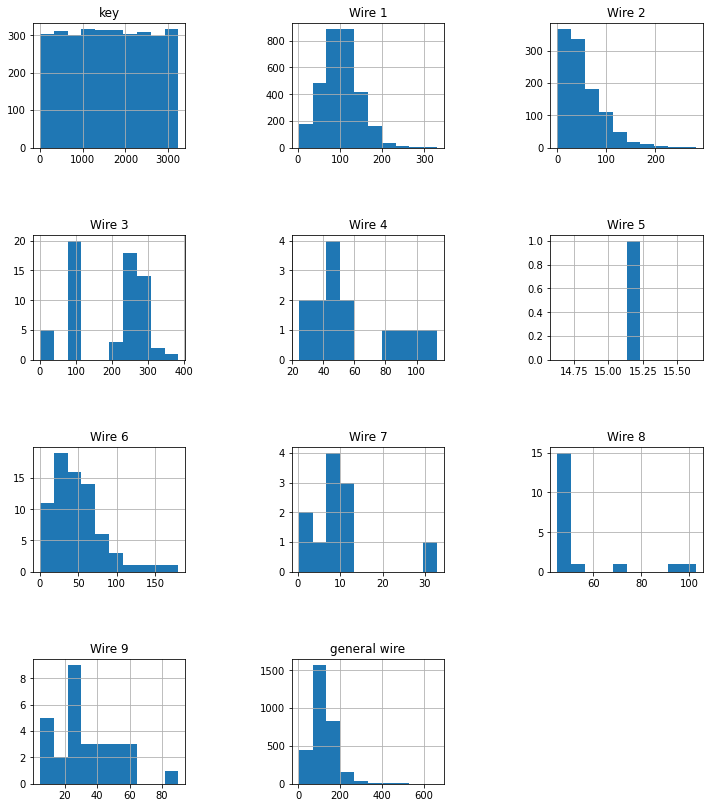

In [38]:
wire_volume.hist(figsize=(12,14))
plt.subplots_adjust(hspace=0.7, wspace=0.7)
plt.show()

In [39]:
wire_volume.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,general wire
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000,3081.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752,123.723326
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616,66.082966
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800,1.918800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401,86.112000
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399,114.179523
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003,150.181198
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604,663.851766


Неадекватных значений не найдено. Также можем отметить что некоторые добавки используются в большом количестве, а некоторые в маленьком. 

Проверим таблицу с временем подачи сыпучих материалов, посмотрим на диапазон времени.

In [40]:
wire_time = wire_time.drop(['key'], axis=1) 
wire_time = wire_time.apply(pd.to_datetime)
tt_n = wire_time.min()
tt_m = wire_time.max()
df_4 = pd.DataFrame([tt_n, tt_m])
df_4

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
1,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


Проверим данные на хронологическую последовательность.

In [41]:
# заполняем пропуски вперед и назад
wire_time = wire_time.fillna(method='ffill').fillna(method='bfill')
for col in wire_time.columns:
    if wire_time[col].is_monotonic:
        print(f'Столбец {col} является монотонно возрастающим')
    else:
        print(f'Столбец {col} не является монотонно возрастающим')

Столбец Wire 1 является монотонно возрастающим
Столбец Wire 2 является монотонно возрастающим
Столбец Wire 3 является монотонно возрастающим
Столбец Wire 4 является монотонно возрастающим
Столбец Wire 5 является монотонно возрастающим
Столбец Wire 6 является монотонно возрастающим
Столбец Wire 7 является монотонно возрастающим
Столбец Wire 8 является монотонно возрастающим
Столбец Wire 9 является монотонно возрастающим


Подведём итог.

В данных не обнаружено аномальных значений. Но наблюдается явный дисбаланс классов. Скорее всего редкоиспользуемые виды материалов также придётся объединить в класс “другое” 

Также можем указать что по диапазону времени данные таблицы совпадают с прочими исследуемыми таблицами. 

К заказчику у нас есть следующий вопрос: устраивает ли заказчика то, что нам придётся объединить редкоиспользуемые виды проволочных материалов в одну группу для предсказания температуры?

### Общий итог

Мы попытались, для себя, на основе данных выстроить цепь событий со сталью опираясь на время в данных. Если мы правильно понимаем, то у нас есть замер температуры в начале перед добавлением сыпучих или проволочных материалов, потом делается новый замер температуры и цикл может продолжаться пока сталь не достигнет нужных производителю показателей, после делается финальный замер температуры. То есть либо два либо больше двух замеров температуры для каждой партии. Главный наш вопрос к заказчику следующий: **какой из этих замеров температуры наша модель должна предсказывать?** 

Если важен самый последний замер температуры, то для обучения модели нам нужно будет создать общий датафрейм, где одна строчка будет содержать события и их значения для одной партии, при этом события благодаря указанию даты и времени в первичных данных будут выстроены хронологически. Где последний замер температуры в партии будет целевым значением. 

Если важен каждый замер температуры (кроме самого первого для каждой партии), то тогда каждый цикл: первичный замер температуры, потом нагревание дугой, после добавление материалов и второй замер температуры, нужно будет сделать отдельной строкой. Где второй замер температуры будет целевым значением. Тут может возникнуть ошибка: модель заметит что последний замер температуры совпадает со значением первичного замера температуры у следующей строчки, поэтому в общей таблице строки нужно будет перемешать.  В таком случае также не понятно что делать со значением газа, так как оно указано для каждой партии и нам неизвестно когда он добавляется.

В любом случае общий механизм работы такой:
 
    Создать общую таблицу исходя из того какой замер температуры является целевым. 

    Извлечь неадекватные реальности данные. 
    
    Провести проверку на мультиколлинеарность.

    Количественные и качественные признаки обработать специальными методами для работы моделей. 

    Разделить данные на выборки.

    Выбрать для модели несколько метрик качества, исходя из которых будем выбирать лучшую модель.

    Создать несколько моделей с автоматическим подбором лучших гиперпараметров. 

    Выбрать лучшую модель и протестировать её.

    Провести анализ важности факторов у лучшей модели. 


### Ответы заказчика.

Заказчик сообщил нам следующее: 
	
	Помимо указанных мощностей существует также полная мощность, которая рассчитывается как корень из суммы квадратов активной и реактивной мощностей. Также полную мощность можно умножить на время работы электродов и получится ещё одна физическая величина - работа. Какую из величин в конечном итоге использовать для модели, заказчик оставляет этот выбор за нами. 

    Отрицательных мощностей в данных заказчика быть не должно, всю партию с таким показателем следует удалить из данных. 

    Объединять или необъединять данные по добавкам, по мнению заказчика это также наш выбор. Для него важно лишь то, чтобы в будущем модель могла принимать к работе указанные в данных виды добавок. 

    Количество газа в данных указано сразу на всю партию, без разделения на циклы.

    Минимальной температурой стоит считать 1350 градусов, партии где в данных встречается значение ниже следует удалить из анализа. 

    Целевой температурой следует считать последнюю температуру, замеряемую после окончания всех циклов нагрева и добавок. 

    Метрикой качества выбрана средняя абсолютная ошибка или MAE <= 6.8

## Построение моделей

### Подготовка общей таблицы

Удалим из данные по партиям, которые по нашему общему с заказчиком мнению являются ошибочными: отрицательные значения реактивной мощности и значения температуры меньше 1350. В таблице electrodes это номер партии 2116. В таблице temp это партии 867, 1214, 1619, 2052 и 2561.

In [42]:
print(electrodes.shape[0])
electrodes = electrodes[electrodes['key'] != 2116]
print(electrodes.shape[0])

14876
14872


In [43]:
print(temp.shape[0])
values = [867, 1214, 1619, 2052, 2561]
temp = temp[temp['key'].isin(values) == False]
print(temp.shape[0])

18091
18064


В нашей финальной таблице мы соберем данные сгруппировав их по партиям, взяв только те партии, данные о которых есть во всех таблицах.

По таблице electrodes посчитаем для каждой партии как Полную мощность, так и Работу (полная мощность умноженная на время). Потом добавим к этой таблице сгруппированную по партиям таблицу temp. И проведём анализ на мультиколлинеарность, дабы выбрать какую из мощностей или работу использовать далее. 

In [44]:
electrodes['Время нагрева дугой'] = electrodes['Конец нагрева дугой'] - electrodes['Начало нагрева дугой']
electrodes['Время нагрева дугой'] = electrodes['Время нагрева дугой'].dt.total_seconds().astype('int64')

electrodes['Полная мощность'] = np.sqrt(electrodes['Активная мощность']**2 + electrodes['Реактивная мощность']**2)
electrodes['Работа'] = electrodes['Полная мощность'] * electrodes['Время нагрева дугой']

electrodes = electrodes[['key','Время нагрева дугой','Активная мощность','Реактивная мощность','Полная мощность','Работа']]
electrodes = electrodes.groupby('key').sum().reset_index()
electrodes.head()

,key,Время нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Работа
0,1,1098,3.036730,2.142821,3.718736,770.282114
1,2,811,2.139408,1.453357,2.588349,481.760005
2,3,655,4.063641,2.937457,5.019223,722.837668
3,4,741,2.706489,2.056992,3.400038,683.455597
4,5,869,2.252950,1.687991,2.816980,512.169934


In [45]:
# чтобы методы groupby() и agg() адекватно сработали, надо закрыть все пропуски
temp = temp.fillna(0)
temp = temp.groupby('key').agg({'Температура': ['first', 'last']}).reset_index()
temp.columns = ['key', 'first','last']

# теперь же все пропуски надо удалить 
print(temp.shape[0])
temp = temp[temp['first'] != 0]
print(temp.shape[0])
temp = temp[temp['last'] != 0]
print(temp.shape[0])
temp.head()

3210
3210
2472


,key,first,last
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [46]:
merged_df = pd.merge(temp, electrodes, on='key')

                          key     first      last  Время нагрева дугой  \
key                  1.000000 -0.014680 -0.080506            -0.032949   
first               -0.014680  1.000000  0.437374            -0.361745   
last                -0.080506  0.437374  1.000000             0.207568   
Время нагрева дугой -0.032949 -0.361745  0.207568             1.000000   
Активная мощность   -0.025653 -0.190133  0.044948             0.716324   
Реактивная мощность -0.023605 -0.187954  0.042296             0.708939   
Полная мощность     -0.024911 -0.189719  0.044012             0.714933   
Работа              -0.024849 -0.329798  0.181944             0.900017   

                     Активная мощность  Реактивная мощность  Полная мощность  \
key                          -0.025653            -0.023605        -0.024911   
first                        -0.190133            -0.187954        -0.189719   
last                          0.044948             0.042296         0.044012   
Время нагрева

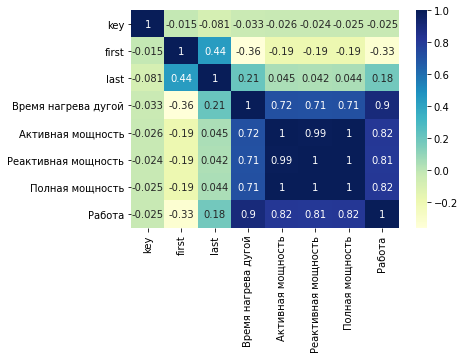

In [47]:
print(merged_df.corr())  
merged_df_plot = sns.heatmap(merged_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Мы видим что у нас имеется сильная корреляция между признаками Времени нагрева дугой, мощностями и работой. Из них нам нужно оставить один либо выбрать несколько не очень сильно коррелирующих друг с другом. С одной стороны хочется оставить Время нагрева дугой, так как у этого признака самая большая корреляция с температурой last. С другой стороны у Работы эта корреляция чуть меньше, но по логике этот признак должен быть наиболее сильно связан с температурой last. Мы также можем взять Время нагрева дугой и Полную мощность, хотя они и коррелируют друг с другом, вместе они и составляют Работу и в тоже время хорошо коррелируют с целевой температурой. Поэтому мы выбираем Время нагрева дугой и Полную мощность. 

In [48]:
merged_df = merged_df[['key', 'Время нагрева дугой', 'Полная мощность', 'first', 'last']]

Добавим данные по газу.

In [49]:
merged_df = pd.merge(merged_df, gas, on='key')
merged_df.head(3)

,key,Время нагрева дугой,Полная мощность,first,last,Газ 1
0,1,1098,3.718736,1571.0,1613.0,29.749986
1,2,811,2.588349,1581.0,1602.0,12.555561
2,3,655,5.019223,1596.0,1599.0,28.554793


Добавим данные по добавкам сыпучих и проволочных материалов.

In [50]:
merged_df = pd.merge(merged_df, bulk_volume, on='key')
merged_df = pd.merge(merged_df, wire_volume, on='key')
merged_df.head(3)

,key,Время нагрева дугой,Полная мощность,first,last,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,general wire
0,1,1098,3.718736,1571.0,1613.0,29.749986,NaN,NaN,NaN,43.0,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,811,2.588349,1581.0,1602.0,12.555561,NaN,NaN,NaN,73.0,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
2,3,655,5.019223,1596.0,1599.0,28.554793,NaN,NaN,NaN,34.0,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157


In [51]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2324 non-null   int64  
 1   Время нагрева дугой  2324 non-null   int64  
 2   Полная мощность      2324 non-null   float64
 3   first                2324 non-null   float64
 4   last                 2324 non-null   float64
 5   Газ 1                2324 non-null   float64
 6   Bulk 1               199 non-null    float64
 7   Bulk 2               13 non-null     float64
 8   Bulk 3               958 non-null    float64
 9   Bulk 4               811 non-null    float64
 10  Bulk 5               53 non-null     float64
 11  Bulk 6               437 non-null    float64
 12  Bulk 7               13 non-null     float64
 13  Bulk 8               1 non-null      float64
 14  Bulk 9               13 non-null     float64
 15  Bulk 10              143 non-null    f

По понятным причинам столбцы с добавками содержат пустые значения. Есть также полностью пустой столбец Wire 5. Удалим его.

In [52]:
print(merged_df.shape[1])
merged_df = merged_df.drop('Wire 5', axis=1)
print(merged_df.shape[1])

32
31


Проверим всю таблицу на мультиколлинеарность. Так как таблица имеет много столбцов, смотреть её всю будет не удобно. Выведем только те столбцы, что могут нас заинтересовать своей коллинеарностью. 

In [53]:
# получение матрицы корреляции
corr_matrix = merged_df.corr()

# создадим новый датафрейм с парами столбцов, у которых корреляция больше 0.69 и не равна 1
corr_pairs = corr_matrix[(corr_matrix > 0.69) & (corr_matrix != 1)].stack().reset_index()
corr_pairs.columns = ['Column 1', 'Column 2', 'Корреляция']
corr_pairs = corr_pairs[corr_pairs['Column 1'] != 'key']
corr_pairs = corr_pairs[corr_pairs['Column 2'] != 'key']
corr_pairs = corr_pairs.sort_values(by=['Корреляция'], ascending=[True]).reset_index(drop=True)
corr_pairs.index = corr_pairs.index + 1

# удалим дублирующиеся пары
corr_pairs = corr_pairs.drop(corr_pairs.index[::2])
print(corr_pairs)

           Column 1             Column 2  Корреляция
2            Wire 6               Bulk 4    0.697244
4           Bulk 11               Bulk 1    0.709720
6   Полная мощность  Время нагрева дугой    0.719234
8            Bulk 9               Wire 8    0.751087
10           Bulk 9               Bulk 4    0.789128
12          Bulk 12         general bulk    0.821542
14           Bulk 4               Wire 8    0.824822
16          Bulk 13               Bulk 6    0.844690
18           Wire 3         general wire    0.928918
20     general wire               Wire 7    0.941477
22          Bulk 12               Bulk 9    0.946954
24           Wire 8              Bulk 12    0.970067
26           Wire 2               Bulk 7    1.000000


Итого. Мы однозначно убираем из таблицы general wire
и general bulk. Также часть упоминаемых тут признаков wire и bulk относятся к немногочисленным. Объединим  wire и bulk, которые встречаются редко.

In [54]:
print(merged_df.shape[1])
merged_df = merged_df.drop('general wire', axis=1)
merged_df = merged_df.drop('general bulk', axis=1)
print(merged_df.shape[1])

31
29


In [55]:
# чтобы сложение сработали, надо закрыть все пропуски
merged_df = merged_df.fillna(0)

Пропуски в данных сосредоточены в столбцах с добавками, а значит каждый пропуск фактически является нулевым значением, т.к. эту добавку просто не добавляли.

In [56]:
print(merged_df.shape[1])
merged_df['Bulk 2578913'] = merged_df[['Bulk 2', 
                                       'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']].sum(axis=1)
print(merged_df.shape[1])

29
30


In [57]:
print(merged_df.shape[1])
merged_df = merged_df.drop('Bulk 2', axis=1)
merged_df = merged_df.drop('Bulk 5', axis=1)
merged_df = merged_df.drop('Bulk 7', axis=1)
merged_df = merged_df.drop('Bulk 8', axis=1)
merged_df = merged_df.drop('Bulk 9', axis=1)
merged_df = merged_df.drop('Bulk 13', axis=1)
print(merged_df.shape[1])

30
24


In [58]:
print(merged_df.shape[1])
merged_df['Wire 346789'] = merged_df[['Wire 3',
                                      'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']].sum(axis=1)
print(merged_df.shape[1])

24
25


In [59]:
print(merged_df.shape[1])
merged_df = merged_df.drop('Wire 3', axis=1)
merged_df = merged_df.drop('Wire 4', axis=1)
merged_df = merged_df.drop('Wire 6', axis=1)
merged_df = merged_df.drop('Wire 7', axis=1)
merged_df = merged_df.drop('Wire 8', axis=1)
merged_df = merged_df.drop('Wire 9', axis=1)
print(merged_df.shape[1])

25
19


In [60]:
merged_df.head()

,key,Время нагрева дугой,Полная мощность,first,last,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Bulk 2578913,Wire 346789
0,1,1098,3.718736,1571.0,1613.0,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0
1,2,811,2.588349,1581.0,1602.0,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0
2,3,655,5.019223,1596.0,1599.0,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0
3,4,741,3.400038,1601.0,1625.0,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0
4,5,869,2.816980,1576.0,1602.0,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0


In [61]:
merged_df = merged_df.drop('key', axis=1)

In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Время нагрева дугой  2324 non-null   int64  
 1   Полная мощность      2324 non-null   float64
 2   first                2324 non-null   float64
 3   last                 2324 non-null   float64
 4   Газ 1                2324 non-null   float64
 5   Bulk 1               2324 non-null   float64
 6   Bulk 3               2324 non-null   float64
 7   Bulk 4               2324 non-null   float64
 8   Bulk 6               2324 non-null   float64
 9   Bulk 10              2324 non-null   float64
 10  Bulk 11              2324 non-null   float64
 11  Bulk 12              2324 non-null   float64
 12  Bulk 14              2324 non-null   float64
 13  Bulk 15              2324 non-null   float64
 14  Wire 1               2324 non-null   float64
 15  Wire 2               2324 non-null   f

In [63]:
merged_df

,Время нагрева дугой,Полная мощность,first,last,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Bulk 2578913,Wire 346789
0,1098,3.718736,1571.0,1613.0,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0
1,811,2.588349,1581.0,1602.0,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0
2,655,5.019223,1596.0,1599.0,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0
3,741,3.400038,1601.0,1625.0,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0
4,869,2.816980,1576.0,1602.0,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,723,3.868721,1570.0,1591.0,7.125735,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,89.150879,0.00000,0.0,0.0
2320,940,5.070316,1554.0,1591.0,9.412616,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,114.179527,0.00000,0.0,0.0
2321,569,4.360918,1571.0,1589.0,6.271699,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,94.086723,9.04800,0.0,0.0
2322,750,3.909917,1591.0,1594.0,14.953657,0.0,90.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0,118.110717,0.00000,0.0,0.0


Таблица готова. Теперь можем создавать модели.

### Создание выборок для моделей

In [64]:
features = merged_df.drop('last', axis=1)
target = merged_df['last']

Для удобства дальнейшей работы с кодом моделей, мы назовём обучающий набор features - X, а обучающий набор target - y. 

In [65]:
# разделение данных на обучающую и тестовую выборки
X, features_test, y, target_test = train_test_split(features, target, 
                                                    test_size=0.25, random_state=50623)

In [66]:
# масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
features_test = scaler.transform(features_test)

Мы будем создавать и настраивать гиперпараметры трёх моделей: CatBoostRegressor, LinearRegression и RandomForestRegressor. После на основании метрики MAE выберем и протестируем лучшую модель. 

### Создадим CatBoostRegressor

In [67]:
# задание параметров для поиска
params_C = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1, 0.15],
    'iterations': [100, 300, 500, 700, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11]
}

# создание модели с автоматическим подбором гиперпараметров
model_C = CatBoostRegressor()
search_C = RandomizedSearchCV(model_C, params_C, n_iter=20,
                              scoring='neg_mean_absolute_error', cv=5, random_state=50623)

# выполнение поиска с помощью tqdm для отображения прогресс-бара
for i in tqdm(range(5)):
    search_C.fit(X_scaled, y, verbose=False)

# вывод метрики качества лучшей модели на валидационных данных
print('Лучшая метрика качества:', abs(search_C.best_score_))

# вывод параметров лучшей модели
print('Лучшие параметры:', search_C.best_params_)

100%|██████████| 5/5 [45:57<00:00, 551.57s/it]

Лучшая метрика качества: 6.124086924633574
Лучшие параметры: {'learning_rate': 0.03, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 6}


### Создадим LinearRegression

In [68]:
model_L = LinearRegression()
scores = cross_val_score(model_L, X_scaled, y, cv=100, 
                         scoring='neg_mean_absolute_error')

avg_score = -scores.mean()
print(avg_score)

6.305146994187477


### Создадим RandomForestRegressor

In [69]:
# задание параметров для поиска
params_R = {'n_estimators': [1, 50],
              'max_depth': [1, 50],
              'min_samples_split': [2, 20],
              'max_features': ['auto', 'sqrt', 'log2', None]}

# создание модели с автоматическим подбором гиперпараметров
model_R = RandomForestRegressor()
search_R = RandomizedSearchCV(model_R, param_distributions=params_R, n_iter=20,
                              cv=5, scoring='neg_mean_absolute_error', random_state=50623)

# выполнение поиска с помощью tqdm для отображения прогресс-бара
for i in tqdm(range(10)):
    search_R.fit(X_scaled, y)

# вывод метрики качества лучшей модели на валидационных данных
print('Лучшая метрика качества:', abs(search_R.best_score_))

# вывод параметров лучшей модели
print('Лучшие параметры:', search_R.best_params_)

100%|██████████| 10/10 [01:50<00:00, 11.03s/it]

Лучшая метрика качества: 6.325526018910832
Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 20, 'max_features': None, 'max_depth': 50}


### Тестирование лучшей модели. 

Лучшей моделью стала CatBoostRegressor

In [70]:
best = CatBoostRegressor(**search_C.best_params_)
best.fit(X_scaled, y, verbose=False)

y_pred = best.predict(features_test)
print('Средняя абсолютная ошибка на тестовой выборке:', mean_absolute_error(target_test, y_pred))

Средняя абсолютная ошибка на тестовой выборке: 6.274644096139347


In [71]:
# получим важность признаков
importance = best.feature_importances_
df_importance = pd.DataFrame({'Feature': features.columns, 'Importance': importance})

# отсортируем по важности признаков
df_importance = df_importance.sort_values('Importance', ascending=False)

# выведим список важности признаков и их названий
print(df_importance)

                Feature  Importance
0   Время нагрева дугой   24.201854
2                 first   23.392976
13               Wire 1    7.257059
7                Bulk 6    6.056967
12              Bulk 15    5.861436
11              Bulk 14    5.360041
14               Wire 2    5.030395
10              Bulk 12    4.083077
1       Полная мощность    4.060649
3                 Газ 1    3.828351
4                Bulk 1    2.726456
5                Bulk 3    2.285387
15         Bulk 2578913    2.051347
6                Bulk 4    1.949344
16          Wire 346789    0.856621
9               Bulk 11    0.717231
8               Bulk 10    0.280810


## Отчёт

Для выполнения нашего проекта заказчик предоставил нам набор таблиц и информацию о выплавке стали. Мы провели первичный анализ данных, составили вопросы к заказчику. На встрече с заказчиком обсудили наши данные и вопросы, выявили что целевой метрикой является последний замер температуры расплавленной стали, когда закончены все этапы добавок и продувкой газом. Заказчик выбрал целевой метрикой среднюю абсолютную ошибку или MAE <= 6.8 градусов.

Мы разработали план выполнения проекта и выполнили все его пункты:

    Создали общую таблицу из всех представленных таблиц заказчика, взяв в работу только те партии стали, информация о которых была во всех таблицах.

    Убрали из работы неадекватные реальности данные, которые заранее обсудили с заказчиком, удалив партии с температурой, меньшей 1350 градусов, и партии с отрицательными значениями мощности. При этом выбросы мы оставили, так как модели должны учитывать реальные данные.

    Провели проверку на мультиколлинеарность и убрали часть данных с высокой корреляцией. Также объединили столбцы с добавками, которые содержали мало значений и коррелировали друг с другом.

    Разделили данные на обучающую и тестовую выборки в соотношении 3:1.

    Для корректной и эффективной работы моделей были масштабированы признаки с помощью метода StandardScaler().

    Мы создали модели CatBoostRegressor и RandomForestRegressor с автоматическим подбором лучших гиперпараметров, а также модель LinearRegression, результаты которой были проверены при использовании кросс-валидации. Все модели достигли показателей метрики MAE < 6.8, но наилучшие результаты продемонстрировала модель CatBoostRegressor, её результаты на тестовой выборке составили 6.27. 

Гиперпараметры лучшей модели были следующими: 

    learning_rate = 0.03 
    l2_leaf_reg = 7 
    iterations = 1000 
    depth = 6

Список признаков, использованных для создания моделей, включал в себя:

    first (начальное измерение температуры)
    Время нагрева дугой
    Газ 1
    Полная мощность
    Bulk 1
    Bulk 3
    Bulk 4
    Bulk 6
    Bulk 10
    Bulk 11
    Bulk 12
    Bulk 14
    Bulk 15    
    Bulk 2578913
    Wire 1
    Wire 2
    Wire 346789

Признаки Bulk 2578913 и Wire 346789 были объединены из разных столбцов, поскольку они коррелировали друг с другом и содержали небольшое число значений. Кроме того, из общей таблицы был удалён столбец Wire 5, так как он был полностью пустой.

В финальной таблице было удалено несколько сотен строк из-за пропущенных значений в столбце с целевой температурой. Учитывая, что только 2324 строки были использованы в финальной таблице, улучшение процесса измерения конечной температуры может увеличить количество данных и улучшить качество будущих моделей.

Кроме того, мы провели анализ важности факторов в лучшей модели. Самыми значимыми факторами, которые значительно превышают другие важные факторы, стали Время нагрева дугой и first (начальное измерение температуры). Нам известно что конечная цель заказчика состоит в уменьшение количества используемой электроэнергии на нагрев стали. Поэтому, вероятно, ключ к сокращению затрат заключается в большем контроле за временем нагрева электродами стали. Однако мы должны предупредить заказчика, что значительное изменение времени работы электродов приведет к изменению их значимости в модели. Это означает, что необходимо будет строить новые модели на новых данных и с новыми гиперпараметрами. 